# Simulation analysis of "simplified connectome models"

<u>Circuits (O1 size, calibrated)</u>:
- Base circuit
- 1st-order hex0-EE rewired
- 2nd-order hex0-EE rewired
- 3rd-order hex0-EE rewired
- 4th-order hex0-EE rewired
- 5th-order hex0-EE rewired

<u>Simulation campaigns</u>:
- Reliability campaigns (pyramidal base stimulus, 32s)
- Random dot stimulus TEST (2s)
- Random dot stimulus CALIBRATION (10s)
- Pyramid base stimulus CALIBRATION (8s)

<u>Notes</u>: Main differences between 1. "Random dot stimulus" and 2. "Pyramid base stimulus" (VPM only)
- Spatial patterns
  1. Patterns drawn such that min. distance between clusters maximized
  2. Patterns restricted to the biggest circle that can be drawn into the hexes (with a 500$\mu m$ radius) <br>Preselection of averaged sized clusters
- Rate patterns
  1. Constant rates at $r_{max}$
  2. Linearly decreasing rates from $r_{max}$ to $r_{min}$
- Drawing spikes
  1. Spikes are first drawn independently for each group (cluster) of fibers, and then mapped to all individual fibers belonging to each group (i.e., synchronous spikes within clusters for both background and patterns)
  2. Spikes independently drawn for fibers within clusters

(Modified from [bernsteinconference2022/simulations_summary.ipynb](https://bbpgitlab.epfl.ch/conn/personal/pokorny/bernsteinconference2022/-/blob/main/simulations_summary.ipynb))

In [1]:
# Initialization
import numpy as np
import os
import pandas as pd
from datetime import datetime
from utils import extract_spikes, extract_rates, extract_single_cell_rates, compute_cell_rate_significance, extract_psths, extract_psths_per_layer, extract_psths_per_pattern
from utils import plot_spikes_per_layer, plot_per_layer, plot_cell_rate_histograms, plot_psths, plot_psths_per_layer, plot_psths_per_pattern

ORDINAL_DICT = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 5: '5th'}


In [2]:
# Figs path
res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab'  # Pyramidal base stimulus, 8 x 8 stimuli, 32s

# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab_tmp'

# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim100__CALIB3'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB3'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB4'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB4B'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB4_4B'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_PyrBaseStim_CALIB1'

# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim500__CALIB1'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim100__CALIB1'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim100__CALIB2'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB1'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim200__CALIB2'
# res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_DotStim500__CALIB1'
figs_path = os.path.join(res_path, 'figures_' + datetime.now().strftime('%Y%m%d'))
if not os.path.exists(res_path):
    os.makedirs(res_path)
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
print(f'INFO: Results path: "{res_path}"')
print(f'INFO: Figs path: "{figs_path}"')

INFO: Results path: "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab"
INFO: Figs path: "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab/figures_20230926"


In [7]:
# Simulation paths
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2'
sim_seed = 582801

order = [1, 2, 3, 4, 5]
circuit_names = ['SSCx-HexO1-Release-TC'] + [f'SSCx-HexO1-Release-TC__ConnRewireOrder{_ord}Hex0EE' for _ord in order]
plot_names = ['Original'] + [f'{ORDINAL_DICT[_ord]} order' for _ord in order]
sim_names = ['SSCx-HexO1-Release-TC__Reliab'] + [f'SSCx-HexO1-Release-TC__Reliab__ConnRewireOrder{_ord}Hex0EE' for _ord in order]
sim_configs = {_c: os.path.join(sim_path, _sim, f'seed={sim_seed}', 'simulation_config.json') for _c, _sim in zip(circuit_names, sim_names)}  # SONATA simulation config

print('Reliab sims:')
for _sim, _cfg in sim_configs.items():
    assert os.path.exists(_cfg)
    print(f'  {_sim}')


Reliab sims:
  SSCx-HexO1-Release-TC
  SSCx-HexO1-Release-TC__ConnRewireOrder1Hex0EE
  SSCx-HexO1-Release-TC__ConnRewireOrder2Hex0EE
  SSCx-HexO1-Release-TC__ConnRewireOrder3Hex0EE
  SSCx-HexO1-Release-TC__ConnRewireOrder4Hex0EE
  SSCx-HexO1-Release-TC__ConnRewireOrder5Hex0EE


In [3]:
# circuit_names = ['SSCx-HexO1-Release-TC']
# plot_names = ['Original']
# sim_names = ['TEST']
# sim_configs = {circuit_names[0]: '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/bbp_workflow_v2/6b56f5a8-d504-4739-991b-3bfd23295f2c/0/simulation_config.json'}

In [5]:
# # rate_max = [10.0, 15.0, 20.0]  # 5.0 MISSING
# rate_max = [15.0, 20.0, 25.0, 30.0]
# circuit_names = [f'rmax{_r}'.replace('.', 'p') for _r in rate_max]
# plot_names = [f'rmax{_r}'.replace('.', 'p') for _r in rate_max]
# # sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__DotStim100__CALIB1/seed=628462/rate_max={_r}/simulation_config.json' for _c, _r in zip(circuit_names, rate_max)}
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__DotStim200__CALIB1/seed=628462/rate_max={_r}/simulation_config.json' for _c, _r in zip(circuit_names, rate_max)}

In [7]:
# # rate_min = [0.5, 1.0]  # 0.0 MISSING
# rate_min = [0.5]  # 0.0, 1.0 MISSING
# circuit_names = [f'rmin{_r}'.replace('.', 'p') for _r in rate_min]
# plot_names = [f'rmin{_r}'.replace('.', 'p') for _r in rate_min]
# # sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__DotStim100__CALIB2/seed=628462/rate_min={_r}/simulation_config.json' for _c, _r in zip(circuit_names, rate_min)}
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__DotStim200__CALIB2/seed=628462/rate_min={_r}/simulation_config.json' for _c, _r in zip(circuit_names, rate_min)}

In [3]:
# # sim_analysis_DotStim500__CALIB1
# seed = 628462
# rate_min = [0.0, 0.1, 0.5]
# rate_max = [25.0, 50.0, 75.0, 100.0]
# rate_min_max = [[_rmn, _rmx] for _rmn in rate_min for _rmx in rate_max]
# rate_min_max = [_rmm for _idx, _rmm in enumerate(rate_min_max) if _idx != 2]  # Filter missing simulations

# circuit_names = [f'r_{_rmn}_{_rmx}'.replace('.', 'p') for _rmn, _rmx in rate_min_max]
# plot_names = circuit_names
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__DotStim500__CALIB1/seed={seed}/rate_min={_rmn}/rate_max={_rmx}/simulation_config.json' for _c, (_rmn, _rmx) in zip(circuit_names, rate_min_max)}

In [3]:
# sim_name = 'DotStim200__CALIB4B'  # DotStim100__CALIB3, DotStim200__CALIB3, DotStim200__CALIB4B
# seed = 628462
# # rate_min = [0.0, 0.1]
# rate_min = [0.0]
# # rate_max = [15.0, 20.0, 25.0, 30.0, 35.0]
# # rate_max = [30.0, 35.0, 40.0, 45.0, 50.0]
# rate_max = [55.0, 60.0, 65.0, 70.0, 75.0]
# rate_min_max = [[_rmn, _rmx] for _rmn in rate_min for _rmx in rate_max]
# # rate_min_max = [_rmm for _idx, _rmm in enumerate(rate_min_max) if _idx != 3]  # Filter missing simulations

# circuit_names = [f'r_{_rmn}_{_rmx}'.replace('.', 'p') for _rmn, _rmx in rate_min_max]
# plot_names = circuit_names
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__{sim_name}/seed={seed}/rate_min={_rmn}/rate_max={_rmx}/simulation_config.json' for _c, (_rmn, _rmx) in zip(circuit_names, rate_min_max)}

In [58]:
# sim_names = ['DotStim200__CALIB4', 'DotStim200__CALIB4B']  # DotStim100__CALIB3, DotStim200__CALIB3, DotStim200__CALIB4B
# seed = 628462
# rate_min = [0.0]
# rate_max = [[30.0, 35.0, 40.0, 45.0, 50.0], [55.0, 60.0, 65.0, 70.0, 75.0]]
# rate_min_max = [[[_rmn, _rmx] for _rmn in rate_min for _rmx in r_max] for r_max in rate_max]

# _circuit_names = [[f'r_{_rmn}_{_rmx}'.replace('.', 'p') for _rmn, _rmx in r_min_max] for r_min_max in rate_min_max]
# _sim_configs = [{_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__{sim_names[_idx]}/seed={seed}/rate_min={_rmn}/rate_max={_rmx}/simulation_config.json' for _c, (_rmn, _rmx) in zip(_circuit_names[_idx], rate_min_max[_idx])}  for _idx in range(len(sim_names))]
# circuit_names = []
# sim_configs = {}
# for _c, _cfg in zip(_circuit_names, _sim_configs):
#     circuit_names = circuit_names + _c
#     sim_configs.update(_cfg)
# plot_names = circuit_names

In [3]:
# sim_name = 'PyrBaseStim_CALIB1'
# seed = 628462
# vpm_max_rate = [25, 30, 35, 40, 45, 50]

# circuit_names = [f'r_{_rmx}'.replace('.', 'p') for _rmx in vpm_max_rate]
# plot_names = circuit_names
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__{sim_name}/seed={seed}/vpm_max_rate={_rmx}/simulation_config.json' for _c, _rmx in zip(circuit_names, vpm_max_rate)}

In [3]:
# sim_name = 'Reliab'
# seeds = [582801, 993793, 133952]

# circuit_names = [str(_seed) for _seed in seeds]
# plot_names = circuit_names
# sim_configs = {_c: f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2/SSCx-HexO1-Release-TC__{sim_name}/seed={_seed}/simulation_config.json' for _c, _seed in zip(circuit_names, seeds)}

### Stimulus-evoked activity (random dot stim/pyramidal base stim)

In [9]:
t_start = 2000 # (ms)
# t_end = 4500 # (ms)
# t_end = 12000 # (ms)
# t_end = 10000 # (ms)
t_end = 34000 # (ms)
node_set = 'hex0'
load_if_existing = True

spikes_dict = extract_spikes(circuit_names, sim_configs, node_set=node_set, save_path=res_path, save_name='spikes_TEST', load_if_existing=load_if_existing)
rates_dict = extract_rates(circuit_names, sim_configs, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='rates_TEST', load_if_existing=load_if_existing)
cell_rates_dict = extract_single_cell_rates(circuit_names, sim_configs, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='cell_rates_TEST', load_if_existing=load_if_existing)

cell_rates_pval_dict = compute_cell_rate_significance(circuit_names, sim_configs, cell_rates_dict['spk_rates'], node_set, save_path=res_path, save_name='cell_rates_TEST_pval', load_if_existing=load_if_existing)
np.testing.assert_array_almost_equal(rates_dict['rates_exc_per_layer'], cell_rates_pval_dict['mean_exc_rates_per_layer'])  # Consistency check
np.testing.assert_array_almost_equal(rates_dict['rates_inh_per_layer'], cell_rates_pval_dict['mean_inh_rates_per_layer'])  # Consistency check


INFO: Spike data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab/spikes_TEST_hex0.npz"
INFO: Rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab/rates_TEST_hex0.npz"
INFO: Cell rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab/cell_rates_TEST_hex0.npz"
INFO: Cell rate p-values loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_Reliab/cell_rates_TEST_pval_hex0.npz"


In [10]:
from bluepysnap import Simulation
import json
spike_files = []
t_stim = None
stim_train = None
for _cn in circuit_names:
    sim = Simulation(sim_configs[_cn])

#     # Random dot stimulus
#     spike_file = sim.config['inputs']['Stimulus_spikeReplay']['spike_file']
#     stim_cfg_file = os.path.splitext(spike_file)[0] + '.json'
#     with open(stim_cfg_file, 'r') as f:
#         stim_cfg = json.load(f)
#     t_stim_tmp = np.array(stim_cfg['props']['time_windows'][:-1])
#     stim_train_tmp = np.array(stim_cfg['props']['stim_train'])

    # Pyramid base stimulus
    sim_dir = os.path.split(sim.config['output']['output_dir'])[0]
    spike_file = os.path.join(sim_dir, sim.config['inputs']['Stimulus_spikeReplayVPM']['spike_file'])
    cmpgn_dir = os.path.split(sim_dir)[0]
    wkflw_cfg_file = os.path.join(cmpgn_dir, 'config.json')
    with open(wkflw_cfg_file, 'r') as f:
        wkflw_cfg = json.load(f)
    stim_stream_fn = f"stimulus_stream__start{wkflw_cfg['attrs']['stim_start']}__end{wkflw_cfg['attrs']['stim_end'] + 1}__rate{wkflw_cfg['attrs']['stim_rate']:.0f}__seed{wkflw_cfg['attrs']['stim_seed']}.txt"
    stim_stream_df = pd.read_csv(os.path.join(cmpgn_dir, 'input_spikes', stim_stream_fn), sep=' ', header=None, names=['Time', 'Pattern'])
    t_stim_tmp = stim_stream_df['Time'].to_numpy()
    stim_train_tmp = np.array([ord(_p) for _p in stim_stream_df['Pattern']]) # Convert pattern strings 'A', 'B', ...
    stim_train_tmp = stim_train_tmp - min(stim_train_tmp)                    # to indices 0, 1, ...

    spike_files.append(spike_file)
    if t_stim is None:
        t_stim = t_stim_tmp
    else:
        np.testing.assert_array_equal(t_stim, t_stim_tmp)
    if stim_train is None:
        stim_train = stim_train_tmp
    else:
        np.testing.assert_array_equal(stim_train, stim_train_tmp)
print(f'STIM TIMES: {t_stim} ms')
print(f'STIM TRAIN: {stim_train}')

STIM TIMES: [ 2000  2500  3000  3500  4000  4500  5000  5500  6000  6500  7000  7500
  8000  8500  9000  9500 10000 10500 11000 11500 12000 12500 13000 13500
 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500
 20000 20500 21000 21500 22000 22500 23000 23500 24000 24500 25000 25500
 26000 26500 27000 27500 28000 28500 29000 29500 30000 30500 31000 31500
 32000 32500 33000 33500] ms
STIM TRAIN: [4 5 1 6 7 4 1 2 6 3 1 7 0 7 1 4 2 0 5 5 6 2 2 1 4 4 3 3 7 0 6 0 1 7 0 5 2
 3 6 1 6 3 2 3 1 7 2 5 5 4 6 3 3 0 2 0 5 0 4 7 4 7 6 5]


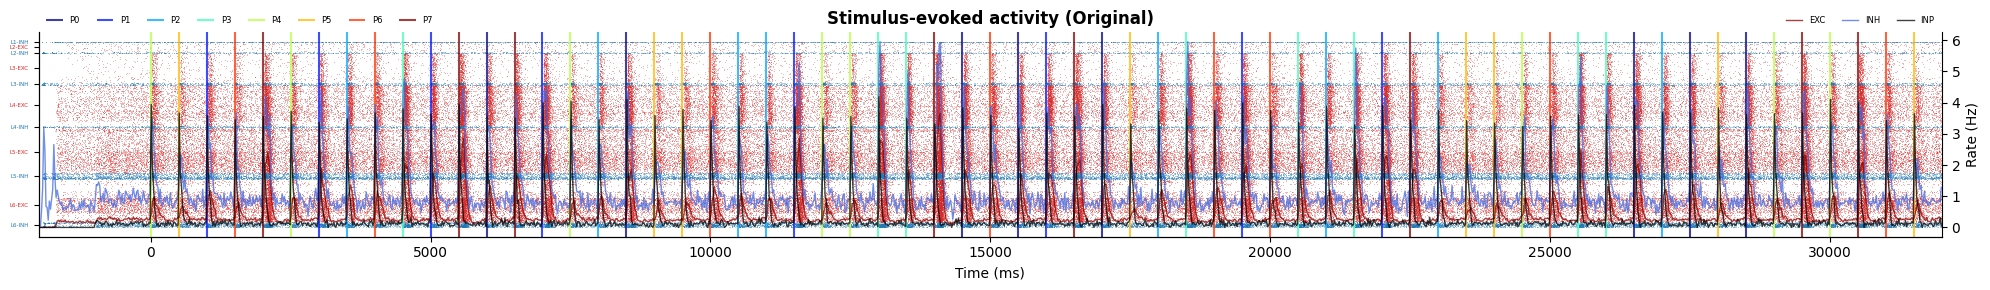

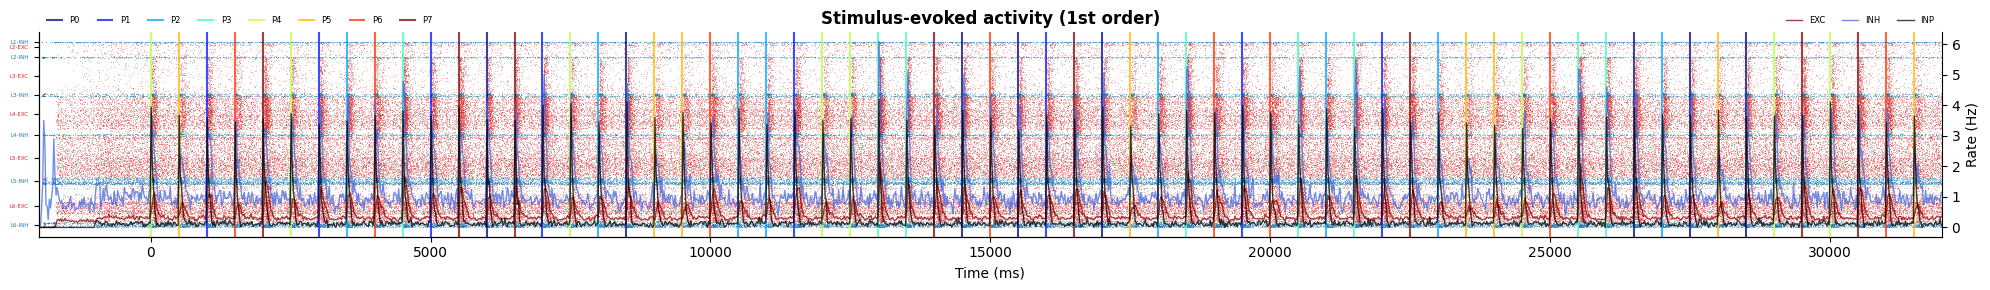

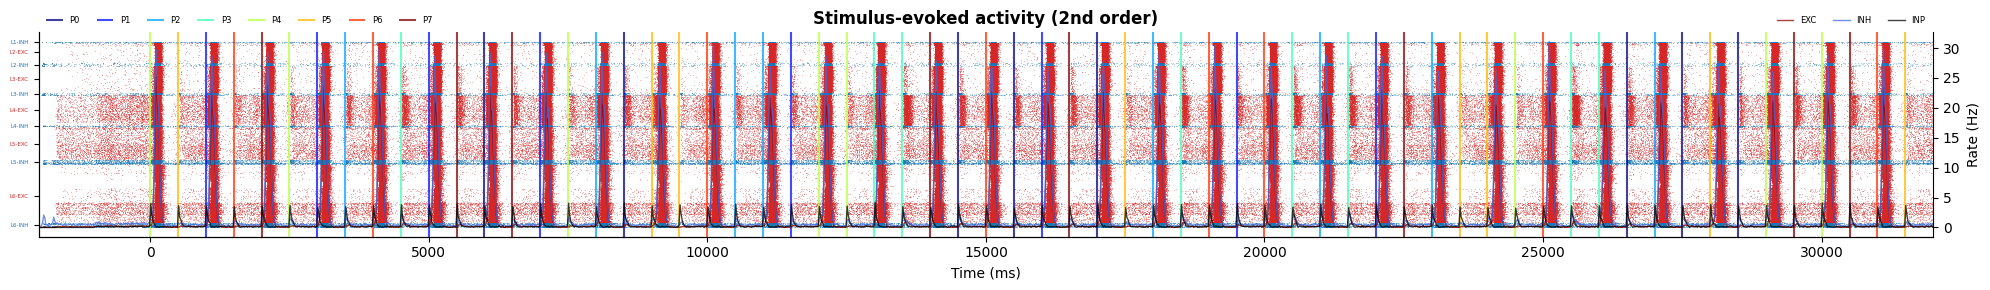

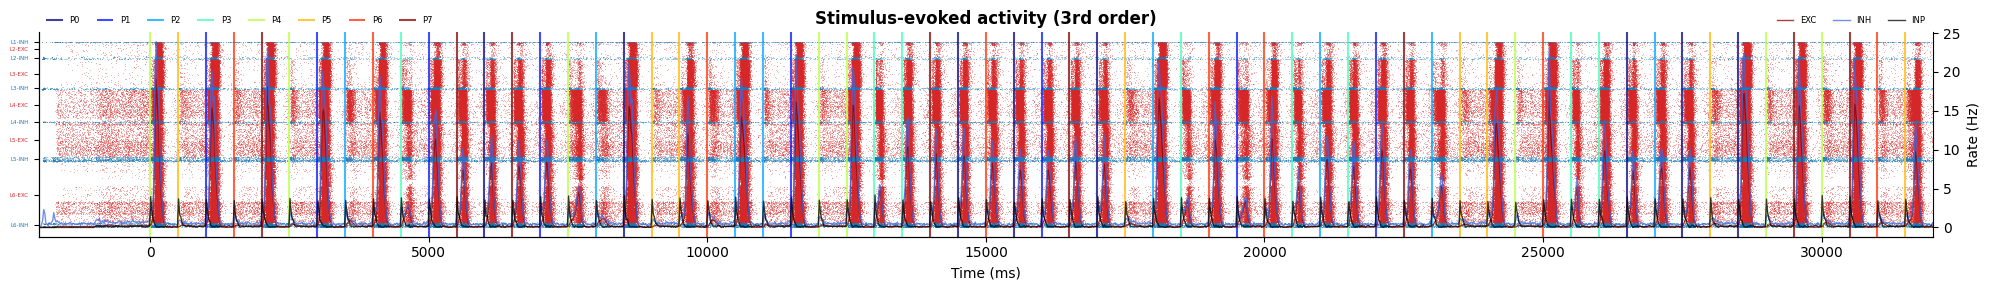

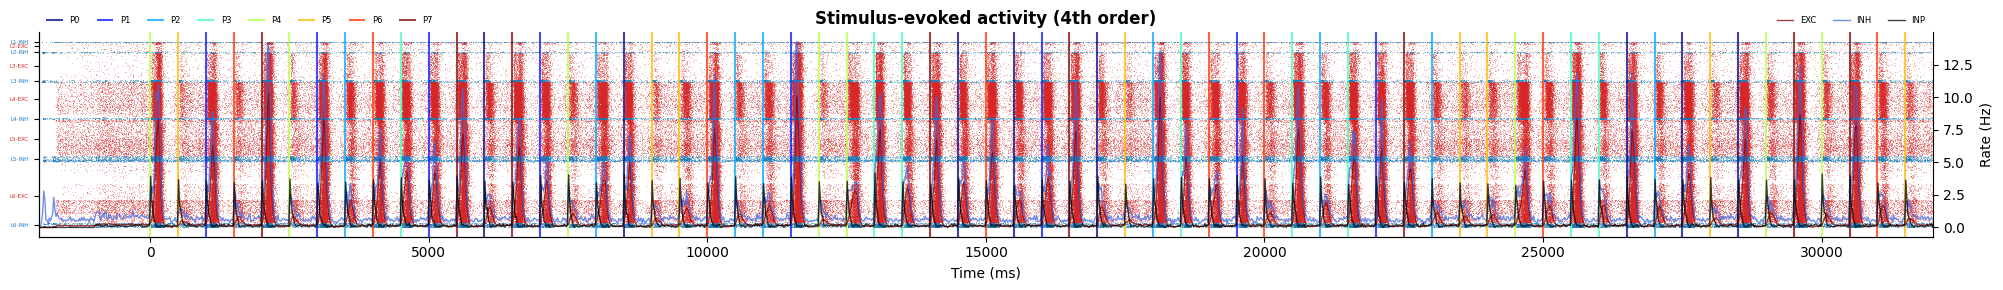

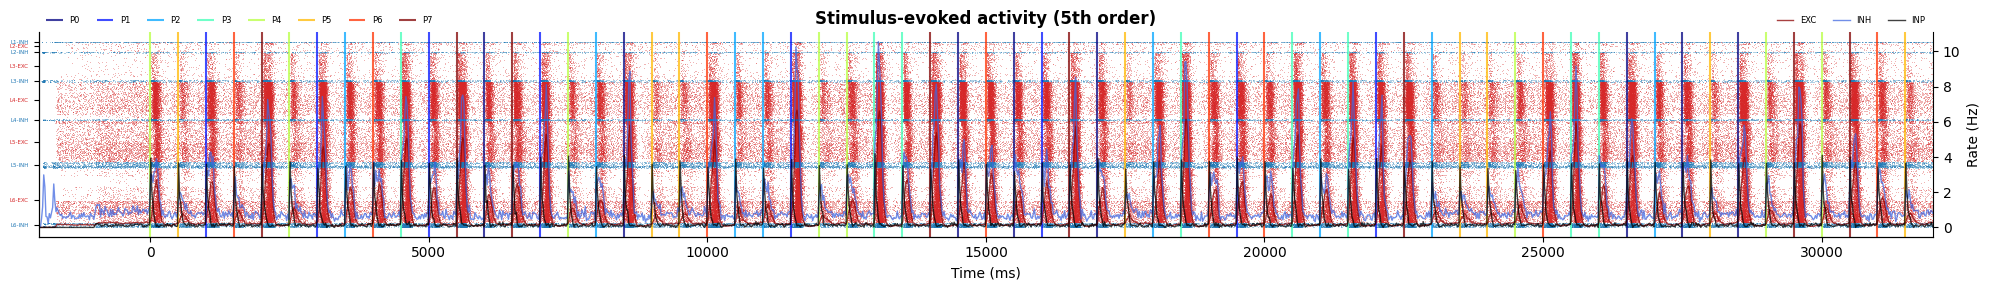

In [11]:
# Plot spike trains of all stimuli
t_start = -2000  # Rel. to t_zero (ms)
# t_end = 10000  # Rel. to t_zero (ms)
# t_end = 8000  # Rel. to t_zero (ms)
t_end = 32000  # Rel. to t_zero (ms)
t_zero = 2000  # Zero-offset (ms)

# psth_dict = {}
sep = ' ' # ' ', '\t'
psth_dict={'EXC': spikes_dict['spk_exc'], 'INH': spikes_dict['spk_inh'], 'INP': [pd.read_csv(_file, sep=sep) for _file in spike_files]}
plot_spikes_per_layer(plot_names, spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_start, t_end, t_zero, t_stim=t_stim, stim_train=stim_train, figsize=(20, 3), save_path=figs_path, psth_dict=psth_dict)

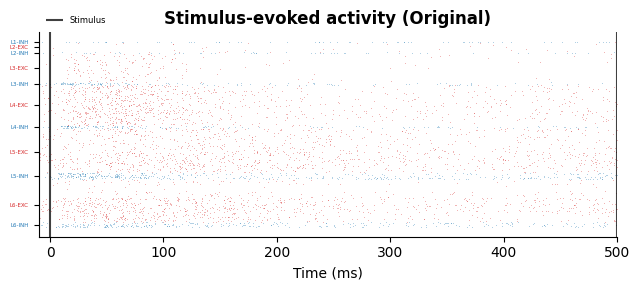

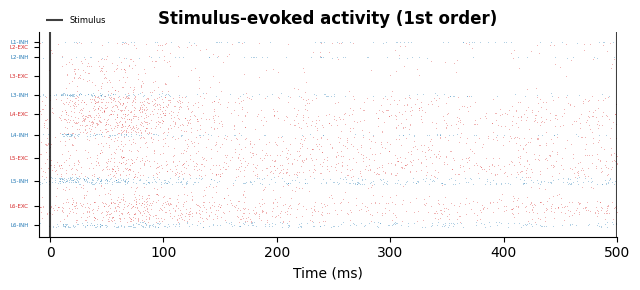

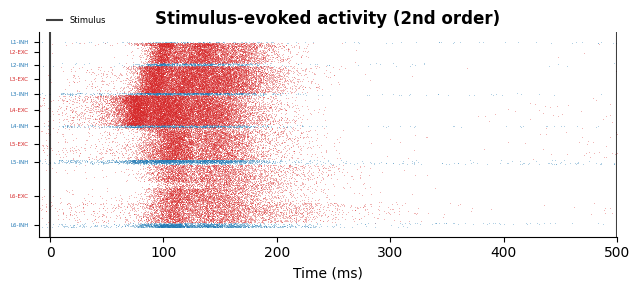

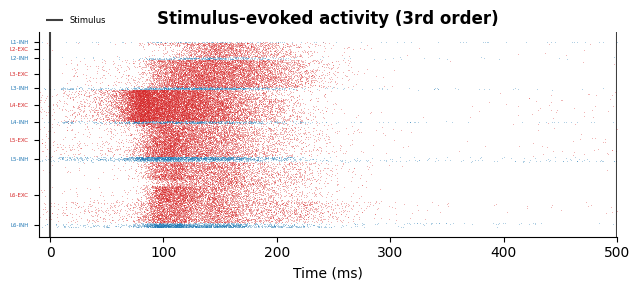

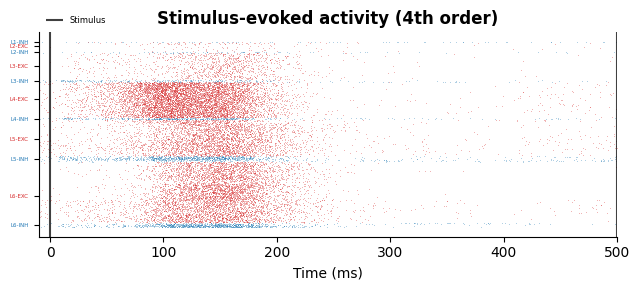

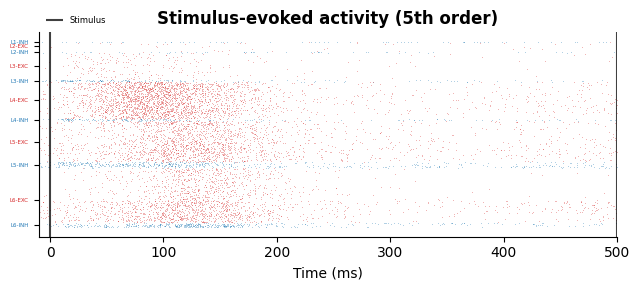

In [12]:
# Plot spike trains of first stimulus
t_start = -10 # (ms)
t_end = 500 # (ms)
t_zero = 2000

plot_spikes_per_layer(plot_names, spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_start, t_end, t_zero, t_stim=t_stim, figsize=(6.5, 3), save_path=figs_path)

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

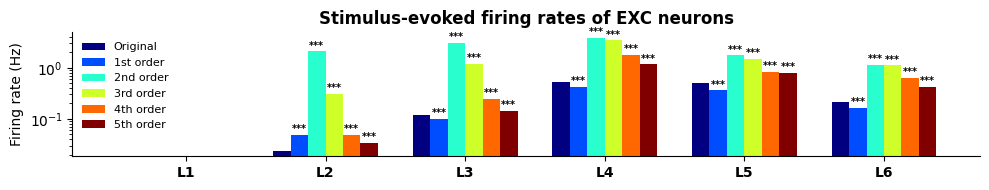

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

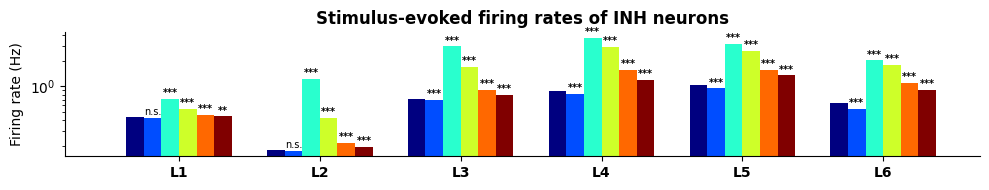

In [15]:
# Plot firing rates per layer
plot_per_layer(rates_dict['rates_exc_per_layer'], plot_names, 'Firing rate (Hz)', f'Stimulus-evoked firing rates of EXC neurons', pvals=cell_rates_pval_dict['p_rates_exc'], log_y=True, figsize=(10, 2), show_legend=True, lgd_props={'loc': 'upper left', 'fontsize': 8, 'ncols': 1, 'frameon': False}, save_path=figs_path)
plot_per_layer(rates_dict['rates_inh_per_layer'], plot_names, 'Firing rate (Hz)', f'Stimulus-evoked firing rates of INH neurons', pvals=cell_rates_pval_dict['p_rates_inh'], log_y=True, figsize=(10, 2), show_legend=False, save_path=figs_path)

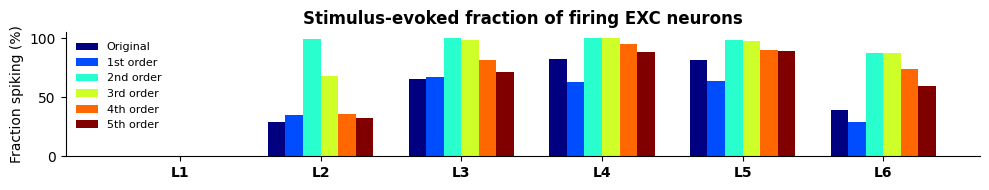

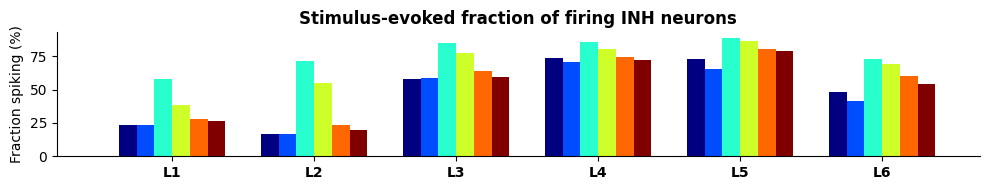

In [17]:
# Plot spiking cell fraction per layer
plot_per_layer(rates_dict['pct_exc_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Stimulus-evoked fraction of firing EXC neurons', log_y=False, figsize=(10, 2), show_legend=True, lgd_props={'loc': 'upper left', 'fontsize': 8, 'ncols': 1, 'frameon': False}, save_path=figs_path)
plot_per_layer(rates_dict['pct_inh_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Stimulus-evoked fraction of firing INH neurons', log_y=False, figsize=(10, 2), show_legend=False, save_path=figs_path)

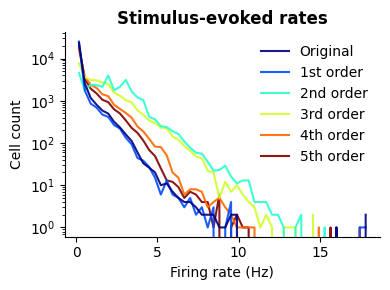

In [32]:
# Plot single-cell rate histograms
plot_cell_rate_histograms(cell_rates_dict['spk_rates'], plot_names, sim_type='Stimulus-evoked', figsize=(4, 3), bins=50, save_path=figs_path)

In [44]:
# Compute & plot PSTHs
# t_psth = [0, 200]
t_psth = [-10, 500]
bin_size = 5  # (ms)
spikes_dict['spk_all'] = [pd.concat([spikes_dict['spk_exc'][_idx], spikes_dict['spk_inh'][_idx]]).sort_index() for _idx in range(len(circuit_names))]
psths_exc, psths_inh, psth_bins = extract_psths(spikes_dict['spk_exc'], spikes_dict['spk_inh'], t_stim, t_psth, bin_size)
psths_all, _, _ = extract_psths(spikes_dict['spk_all'], [pd.DataFrame([])] * len(circuit_names), t_stim, t_psth, bin_size)
psths_exc_per_layer, psths_inh_per_layer, _ = extract_psths_per_layer(spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_stim, t_psth, bin_size)
pattern_psths_exc, pattern_psths_inh, _ = extract_psths_per_pattern(spikes_dict['spk_exc'], spikes_dict['spk_inh'], t_stim, stim_train, t_psth, bin_size)
pattern_psths_all, _, _ = extract_psths_per_pattern(spikes_dict['spk_all'], [], t_stim, stim_train, t_psth, bin_size)

/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:327: RuntimeWarning: invalid value encountered in divide
  psth = 1e3 * np.histogram(stim_spikes.index, bins=bins)[0] / (bin_size * n_all * len(t_stim))
/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:327: RuntimeWarning: invalid value encountered in divide
  psth = 1e3 * np.histogram(stim_spikes.index, bins=bins)[0] / (bin_size * n_all * len(t_stim))
/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:327: RuntimeWarning: invalid value encountered in divide
  psth = 1e3 * np.histogram(stim_spikes.index, bins=bins)[0] / (bin_size * n_all * len(t_stim))
/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:327: RuntimeWarning: invalid value encountered in divide
  psth = 1e3 * np.histogram(stim_spikes.index, bins=

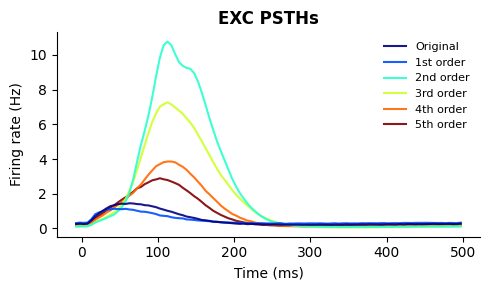

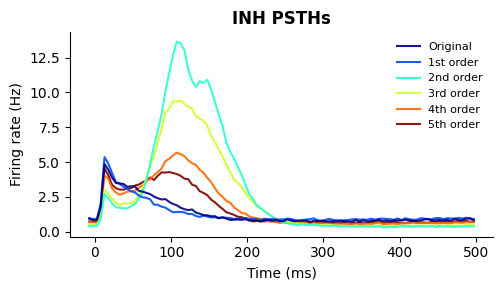

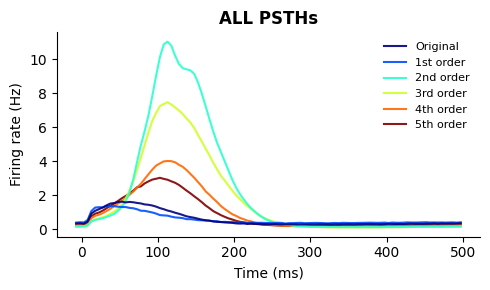

In [36]:
plot_psths(psths_exc, psth_bins, plot_names, 'EXC', figsize=(5, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 8, 'bbox_to_anchor': [1.0, 1.0], 'frameon': False})
plot_psths(psths_inh, psth_bins, plot_names, 'INH', figsize=(5, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 8, 'bbox_to_anchor': [1.0, 1.0], 'frameon': False})
plot_psths(psths_all, psth_bins, plot_names, 'ALL', figsize=(5, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 8, 'bbox_to_anchor': [1.0, 1.0], 'frameon': False})

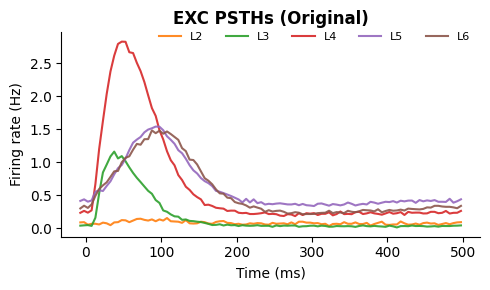

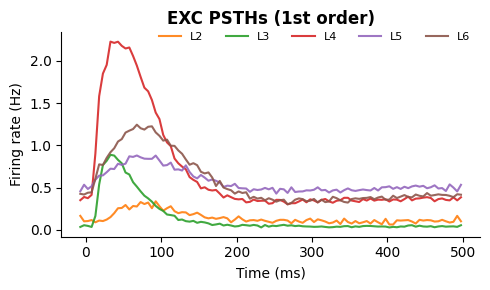

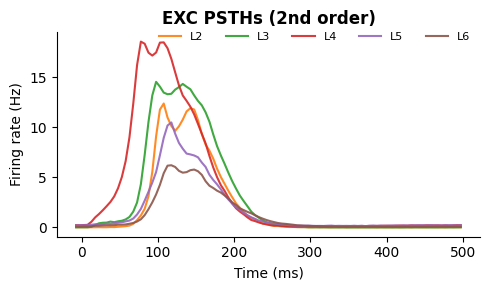

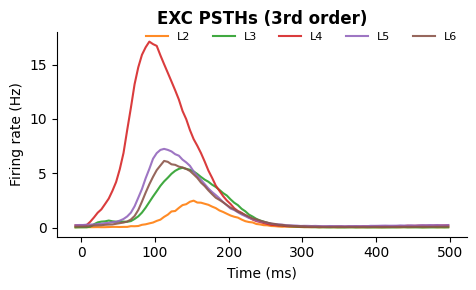

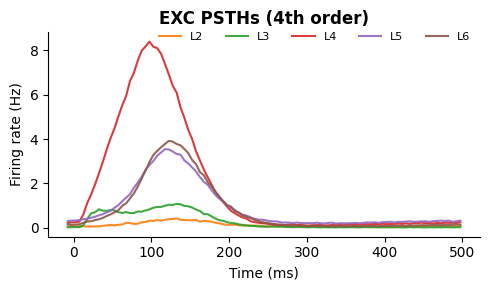

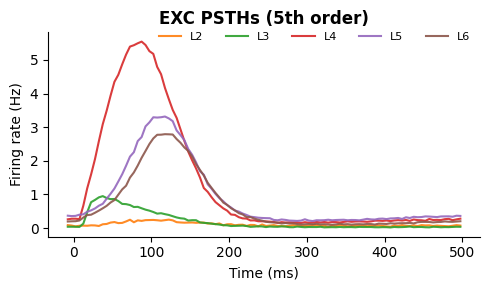

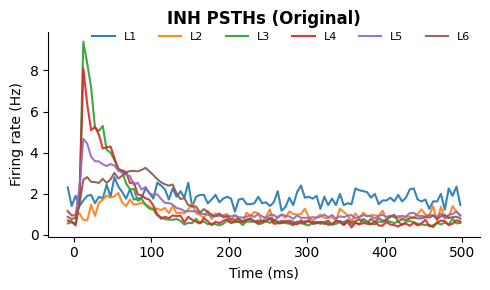

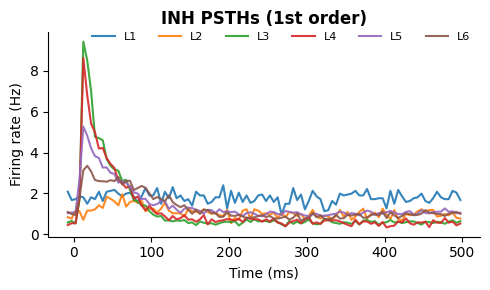

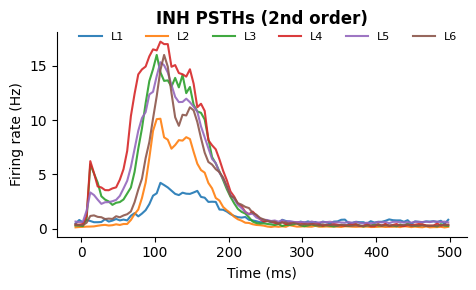

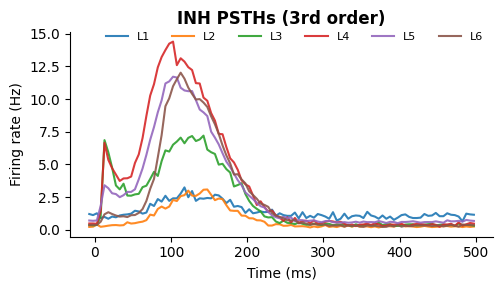

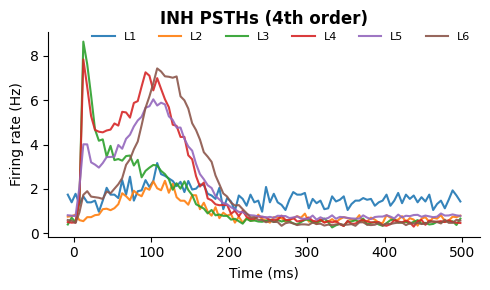

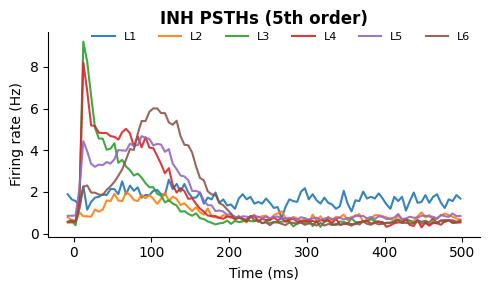

In [37]:
plot_psths_per_layer(psths_exc_per_layer, psth_bins, plot_names, 'EXC', figsize=(5, 3), save_path=figs_path, show_legend=True, lgd_props={'loc': 'upper right', 'ncols': 5, 'fontsize': 8, 'frameon': False, 'bbox_to_anchor': [1.0, 1.05]})
plot_psths_per_layer(psths_inh_per_layer, psth_bins, plot_names, 'INH', figsize=(5, 3), save_path=figs_path, show_legend=True, lgd_props={'loc': 'upper right', 'ncols': 6, 'fontsize': 8, 'frameon': False, 'bbox_to_anchor': [1.0, 1.05]})

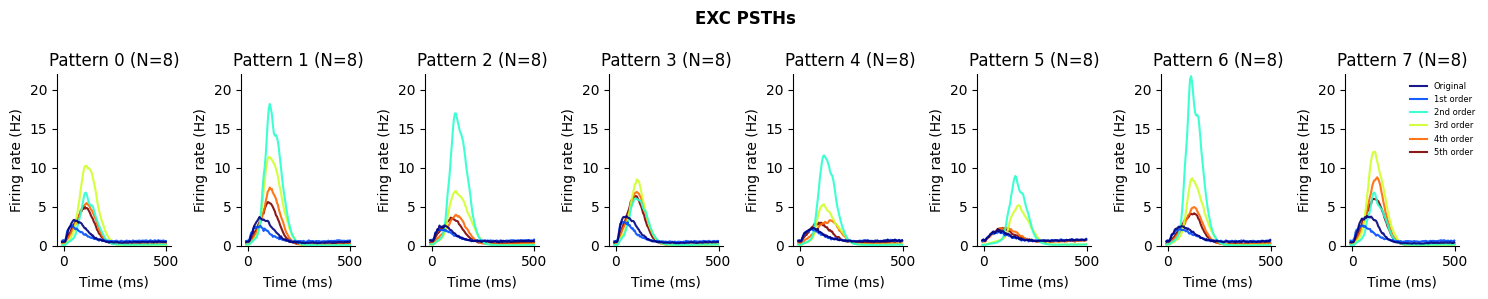

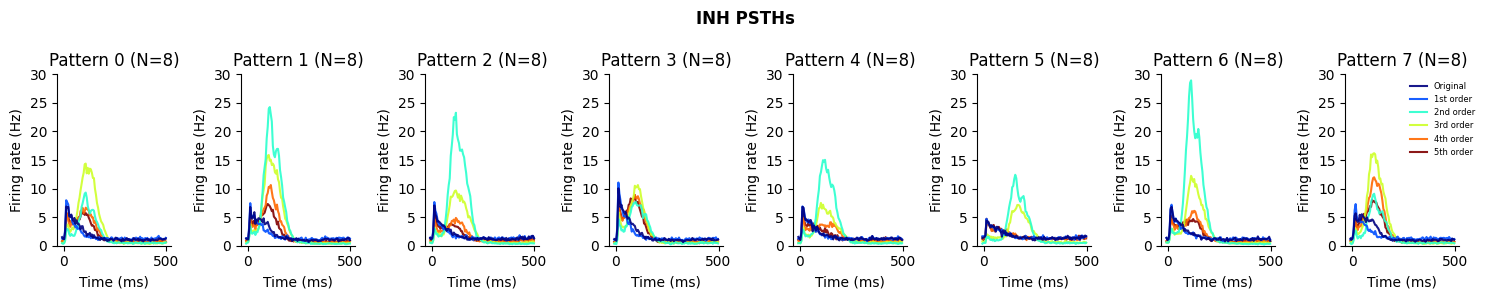

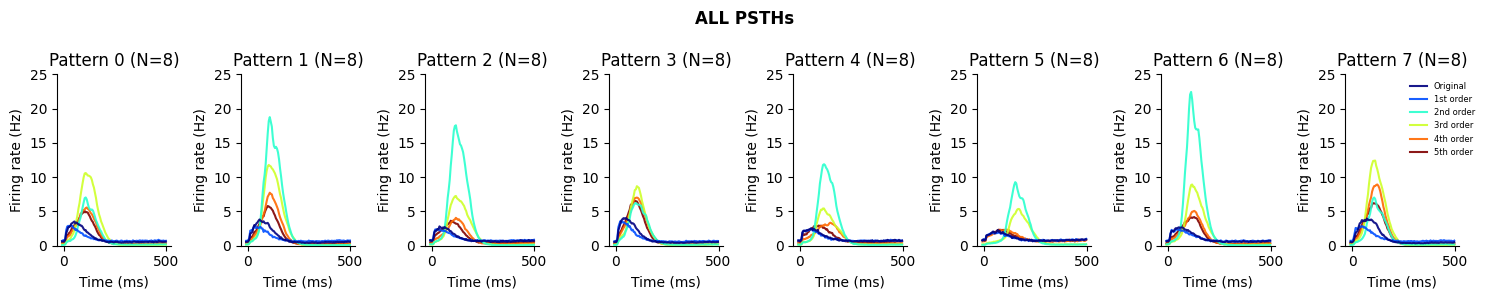

In [64]:
plot_psths_per_pattern(pattern_psths_exc, psth_bins, plot_names, 'EXC', stim_train, ymax=22.0, figsize=(15, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 6, 'bbox_to_anchor': [1.2, 1.0], 'frameon': False})
plot_psths_per_pattern(pattern_psths_inh, psth_bins, plot_names, 'INH', stim_train, ymax=30.0, figsize=(15, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 6, 'bbox_to_anchor': [1.2, 1.0], 'frameon': False})
plot_psths_per_pattern(pattern_psths_all, psth_bins, plot_names, 'ALL', stim_train, ymax=25.0, figsize=(15, 3), save_path=figs_path, lgd_props={'loc': 'upper right', 'ncols': 1, 'fontsize': 6, 'bbox_to_anchor': [1.2, 1.0], 'frameon': False})

In [ ]:
# Trim PNGs
# mogrify -trim *.png